In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)

from numpy.random import seed
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [2]:
# set random seeds
seed(128)
tf.random.set_seed(128)

In [3]:
# load, average and merge sensor samples
data_dir = "data/Bearing_Sensor"
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    if filename == "__MACOSX":
        continue
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = pd.DataFrame(np.array(dataset.abs().mean()).reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

In [4]:
merged_data.index = pd.to_datetime(merged_data.index, format="%Y.%m.%d.%H.%M.%S")
merged_data = merged_data.sort_index()
merged_data.to_csv("Averaged_BearingTest_Dataset.csv")
print("Dataset shape:", merged_data.shape)
merged_data.head(10)

Dataset shape: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659
2004-02-12 11:42:39,0.061231,0.074172,0.082022,0.043840
2004-02-12 11:52:39,0.062280,0.075808,0.084372,0.044272
2004-02-12 12:02:39,0.059890,0.075115,0.084506,0.043974
2004-02-12 12:12:39,0.062371,0.075505,0.082238,0.044171
2004-02-12 12:22:39,0.060837,0.074648,0.080552,0.043602


In [5]:
train = merged_data['2004-02-12 10:52:39':'2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print('Training dataset shape:', train.shape)
print('Test dataset shape:', test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


Now the datasets are set.

Let's make some plot to see the patterns

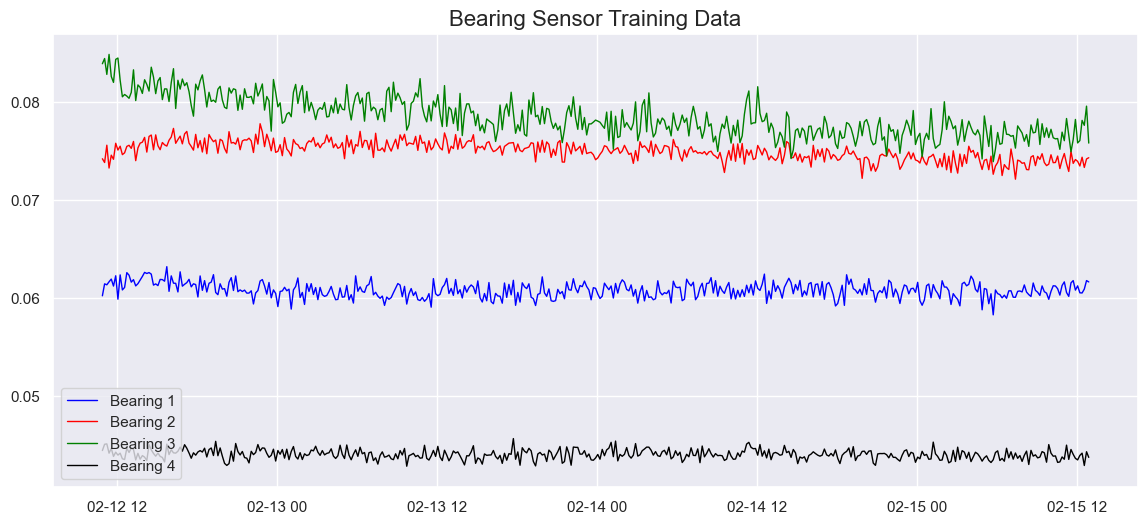

In [6]:
fig, ax = plt.subplots(figsize=(14,6), dpi=100)
ax.plot(train['Bearing 1'], label = 'Bearing 1', color='blue', animated = True, linewidth = 1)
ax.plot(train['Bearing 2'], label = 'Bearing 2', color='red', animated = True, linewidth = 1)
ax.plot(train['Bearing 3'], label = 'Bearing 3', color='green', animated = True, linewidth = 1)
ax.plot(train['Bearing 4'], label = 'Bearing 4', color='black', animated = True, linewidth = 1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize = 16)
plt.show()

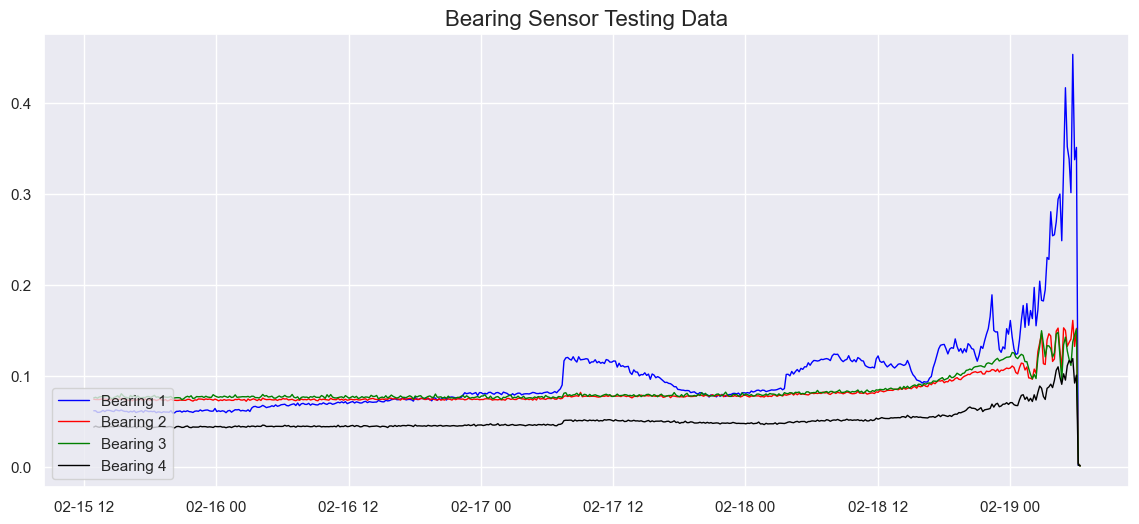

In [7]:
fig, ax = plt.subplots(figsize=(14,6), dpi=100)
ax.plot(test['Bearing 1'], label = 'Bearing 1', color='blue', animated = True, linewidth = 1)
ax.plot(test['Bearing 2'], label = 'Bearing 2', color='red', animated = True, linewidth = 1)
ax.plot(test['Bearing 3'], label = 'Bearing 3', color='green', animated = True, linewidth = 1)
ax.plot(test['Bearing 4'], label = 'Bearing 4', color='black', animated = True, linewidth = 1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Testing Data', fontsize = 16)
plt.show()

**frequency fourier transform:**

transforming data from the time domain to the frequency doamin using fast fourier transform

In [8]:
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

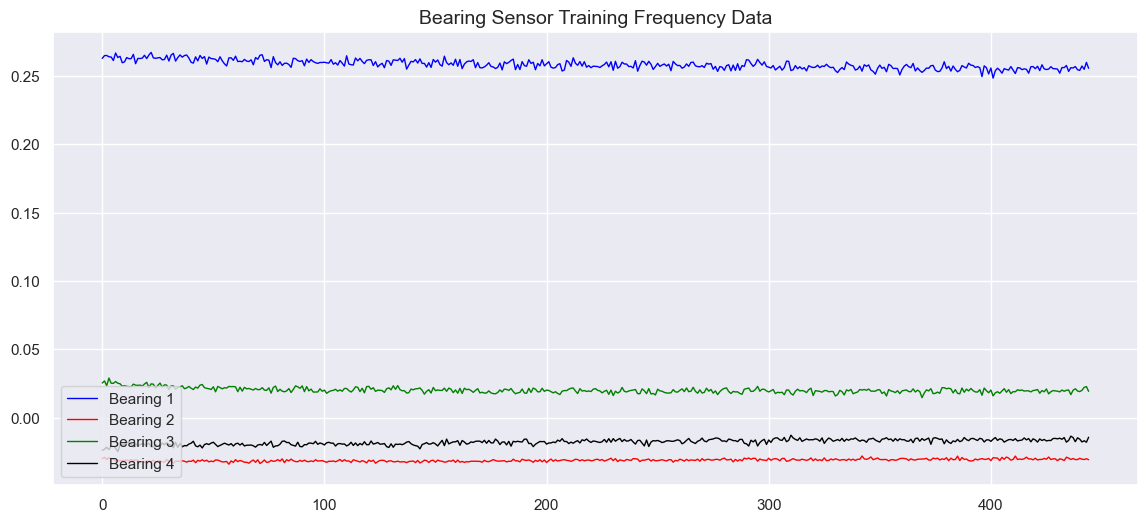

In [9]:
fig, ax = plt.subplots(figsize=(14,6), dpi=100)
ax.plot(train_fft[:,0].real, label = 'Bearing 1', color='blue', animated = True, linewidth = 1)
ax.plot(train_fft[:,1].imag, label = 'Bearing 2', color='red', animated = True, linewidth = 1)
ax.plot(train_fft[:,2].real, label = 'Bearing 3', color='green', animated = True, linewidth = 1)
ax.plot(train_fft[:,3].real, label = 'Bearing 4', color='black', animated = True, linewidth = 1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize = 14)
plt.show()

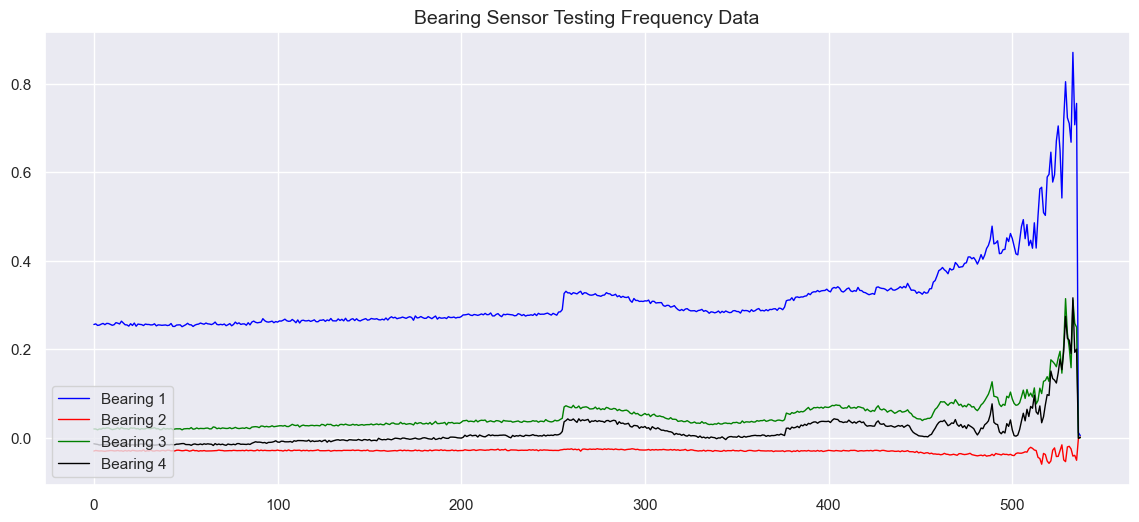

In [10]:
fig, ax = plt.subplots(figsize=(14,6), dpi=100)
ax.plot(test_fft[:,0].real, label = 'Bearing 1', color='blue', animated = True, linewidth = 1)
ax.plot(test_fft[:,1].imag, label = 'Bearing 2', color='red', animated = True, linewidth = 1)
ax.plot(test_fft[:,2].real, label = 'Bearing 3', color='green', animated = True, linewidth = 1)
ax.plot(test_fft[:,3].real, label = 'Bearing 4', color='black', animated = True, linewidth = 1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Testing Frequency Data', fontsize = 14)
plt.show()

Continue presprocessing the data:

- normalize to (0,1)
- reahpe to be suitable to the input of LSTM: (data samples, time steps, features)

In [11]:
# normalize
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = 'scaler_data'
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [12]:
# reshape
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print('Training Data shape:', X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print('Test Data shape:', X_test.shape)

Training Data shape: (445, 1, 4)
Test Data shape: (538, 1, 4)


**Keras LSTM:**

In [13]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1],X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [14]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1344      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)              68    

In [15]:
# fit the model to the data
n_epochs = 100
batch_size = 10

import time

t0 = time.time()
history = model.fit(X_train, X_train, epochs=n_epochs, batch_size=batch_size,
                    validation_split=0.05).history
print('Fitting time: %.4f s'% (time.time()-t0))

Epoch 1/100
43/43 [==============================] - 9s 70ms/step - loss: 0.4574 - val_loss: 0.3207
Epoch 2/100
43/43 [==============================] - 2s 41ms/step - loss: 0.4045 - val_loss: 0.2490
Epoch 3/100
43/43 [==============================] - 2s 39ms/step - loss: 0.3127 - val_loss: 0.1505
Epoch 4/100
43/43 [==============================] - 2s 40ms/step - loss: 0.1640 - val_loss: 0.1183
Epoch 5/100
43/43 [==============================] - 2s 40ms/step - loss: 0.1058 - val_loss: 0.1205
Epoch 6/100
43/43 [==============================] - 2s 38ms/step - loss: 0.1052 - val_loss: 0.1213
Epoch 7/100
43/43 [==============================] - 2s 40ms/step - loss: 0.1044 - val_loss: 0.1157
Epoch 8/100
43/43 [==============================] - 2s 39ms/step - loss: 0.1053 - val_loss: 0.1168
Epoch 9/100
43/43 [==============================] - 2s 40ms/step - loss: 0.0999 - val_loss: 0.1167
Epoch 10/100
43/43 [==============================] - 2s 39ms/step - loss: 0.1026 - val_loss: 0.1159

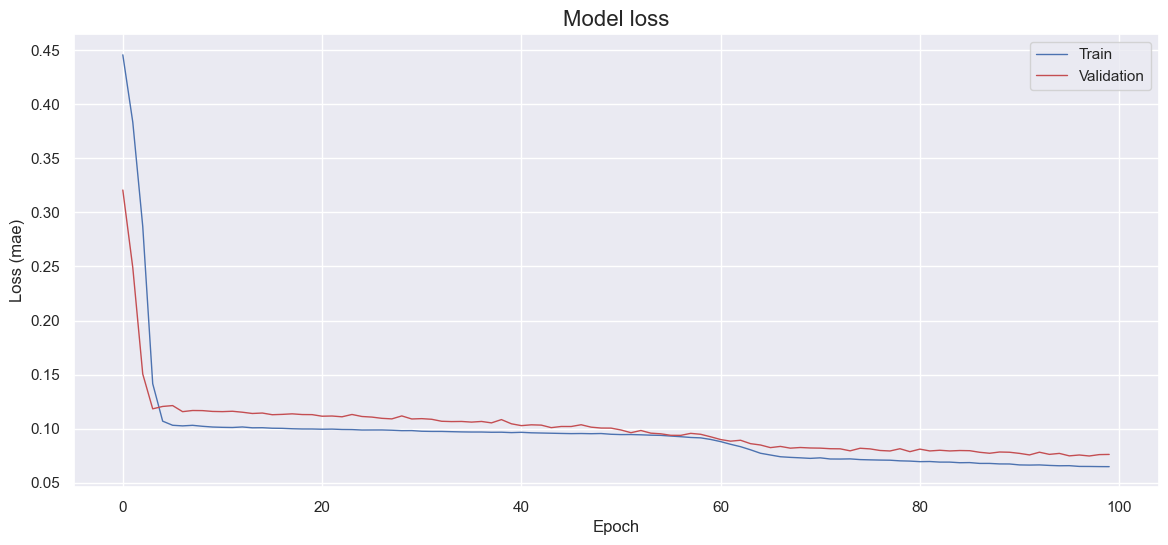

In [16]:
fig, ax = plt.subplots(figsize=(14,6), dpi = 100)
ax.plot(history['loss'], 'b', label = 'Train', linewidth=1)
ax.plot(history['val_loss'], 'r', label = 'Validation', linewidth=1)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

**Loss Distribution**

By plotting the distribution of the calculated loss in the training set, we can determine a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” so that false positives are not triggered.

C:\Program Files\Anaconda\envs\gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.4)

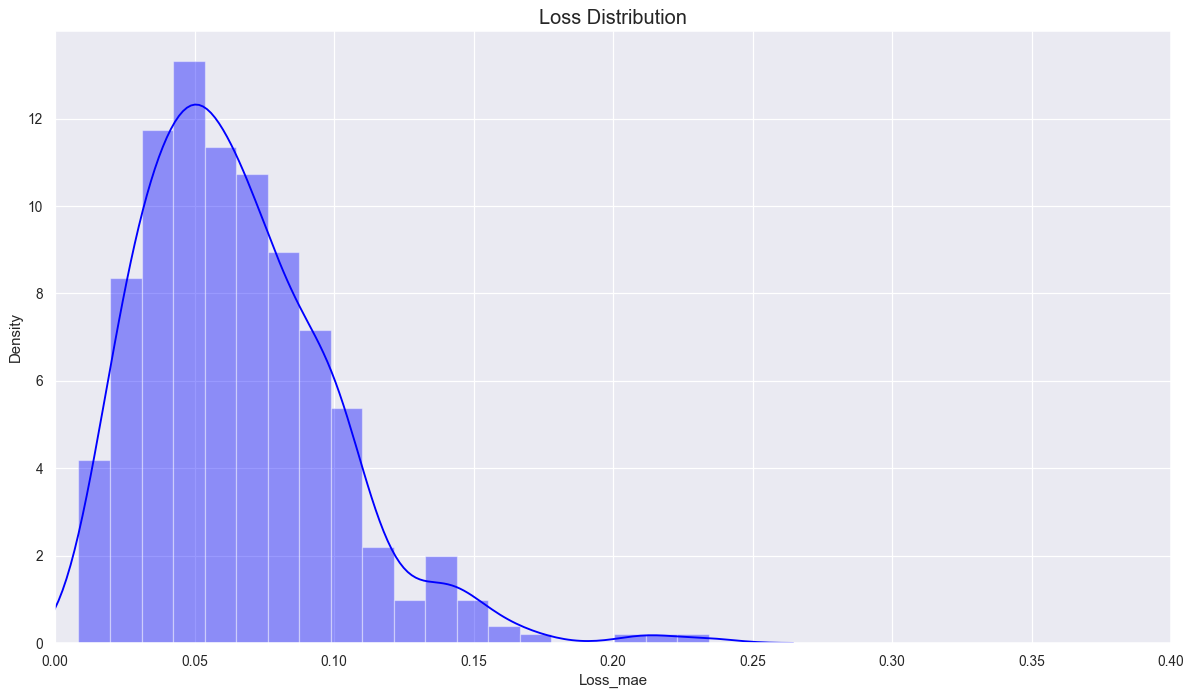

In [17]:
# plot the loss distribution of training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored_train = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored_train['Loss_mae'] = np.mean(np.abs(Xtrain-X_pred), axis = 1)
plt.figure(figsize=(16,9), dpi=90)
plt.title('Loss Distribution', fontsize = 16)
sns.distplot(scored_train['Loss_mae'], bins=20, kde=True, color = 'blue')
plt.xlim([0.0, .4])

In [25]:
X_pred

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.580485,0.781103,0.837143,0.407220
2004-02-12 11:02:39,0.701297,0.824114,0.825595,0.647837
2004-02-12 11:12:39,0.743309,0.818425,0.782188,0.748587
2004-02-12 11:22:39,0.569689,0.809293,0.897795,0.361437
2004-02-12 11:32:39,0.670925,0.769178,0.746036,0.621203
...,...,...,...,...
2004-02-15 12:12:39,0.414702,0.377954,0.193253,0.359149
2004-02-15 12:22:39,0.501400,0.511469,0.385190,0.444281
2004-02-15 12:32:39,0.339990,0.422972,0.333007,0.158566
2004-02-15 12:42:39,0.581620,0.598188,0.490367,0.554755


In [ ]:
fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(train, label = 'Bearing 1 original', color='blue', animated = True, linewidth = 1)
ax.plot(, label = 'Bearing 1 predicted', color='red', animated = True, linewidth = 1)

In [26]:
scored_train['Threshold'] = 0.25
scored_train['Anomoly'] = scored_train['Loss_mae']>scored_train['Threshold']
scored_train.head(10)

,Loss_mae,Threshold,Anomoly
2004-02-12 10:52:39,0.208706,0.25,False
2004-02-12 11:02:39,0.216030,0.25,False
2004-02-12 11:12:39,0.103937,0.25,False
2004-02-12 11:22:39,0.234308,0.25,False
2004-02-12 11:32:39,0.119791,0.25,False
2004-02-12 11:42:39,0.113208,0.25,False
2004-02-12 11:52:39,0.118412,0.25,False
2004-02-12 12:02:39,0.164152,0.25,False
2004-02-12 12:12:39,0.100034,0.25,False
2004-02-12 12:22:39,0.061314,0.25,False


In [30]:
X_test_pred = model.predict(X_test)
X_test_pred = X_test_pred.reshape(X_test_pred.shape[0], X_test_pred.shape[2])
X_test_pred = pd.DataFrame(X_test_pred, columns=test.columns)
X_test_pred.index=test.index

scored_pred = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored_pred['Loss_mae'] = np.mean(np.abs(Xtest-X_test_pred), axis = 1)
scored_pred['Threshold'] = 0.25
scored_pred['Anomoly'] = scored_pred['Loss_mae']>scored_pred['Threshold']

In [31]:
scored=pd.concat([scored_train, scored_pred])
scored.head(10)

,Loss_mae,Threshold,Anomoly
2004-02-12 10:52:39,0.208706,0.25,False
2004-02-12 11:02:39,0.216030,0.25,False
2004-02-12 11:12:39,0.103937,0.25,False
2004-02-12 11:22:39,0.234308,0.25,False
2004-02-12 11:32:39,0.119791,0.25,False
2004-02-12 11:42:39,0.113208,0.25,False
2004-02-12 11:52:39,0.118412,0.25,False
2004-02-12 12:02:39,0.164152,0.25,False
2004-02-12 12:12:39,0.100034,0.25,False
2004-02-12 12:22:39,0.061314,0.25,False


<AxesSubplot:>

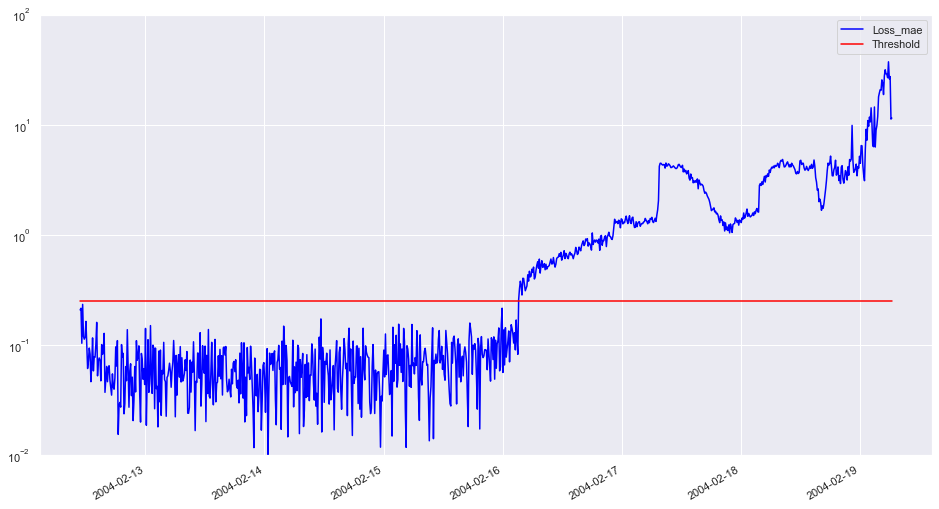

In [32]:
scored.plot(logy=True, figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

In [33]:
scored['Bearing 1'] = merged_data['Bearing 1']
scored['Bearing 2'] = merged_data['Bearing 2']
scored['Bearing 3'] = merged_data['Bearing 3']
scored['Bearing 4'] = merged_data['Bearing 4']

anomalies = scored[scored['Anomoly'] == True]
scored

,Loss_mae,Threshold,Anomoly,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.208706,0.25,False,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.216030,0.25,False,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.103937,0.25,False,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.234308,0.25,False,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.119791,0.25,False,0.061944,0.074593,0.082626,0.044659
...,...,...,...,...,...,...,...
2004-02-19 05:42:39,37.310948,0.25,True,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,26.114103,0.25,True,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,27.403437,0.25,True,0.351111,0.152266,0.151299,0.100817
2004-02-19 06:12:39,11.265527,0.25,True,0.001857,0.003732,0.003656,0.001786


C:\Program Files\Anaconda\envs\gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


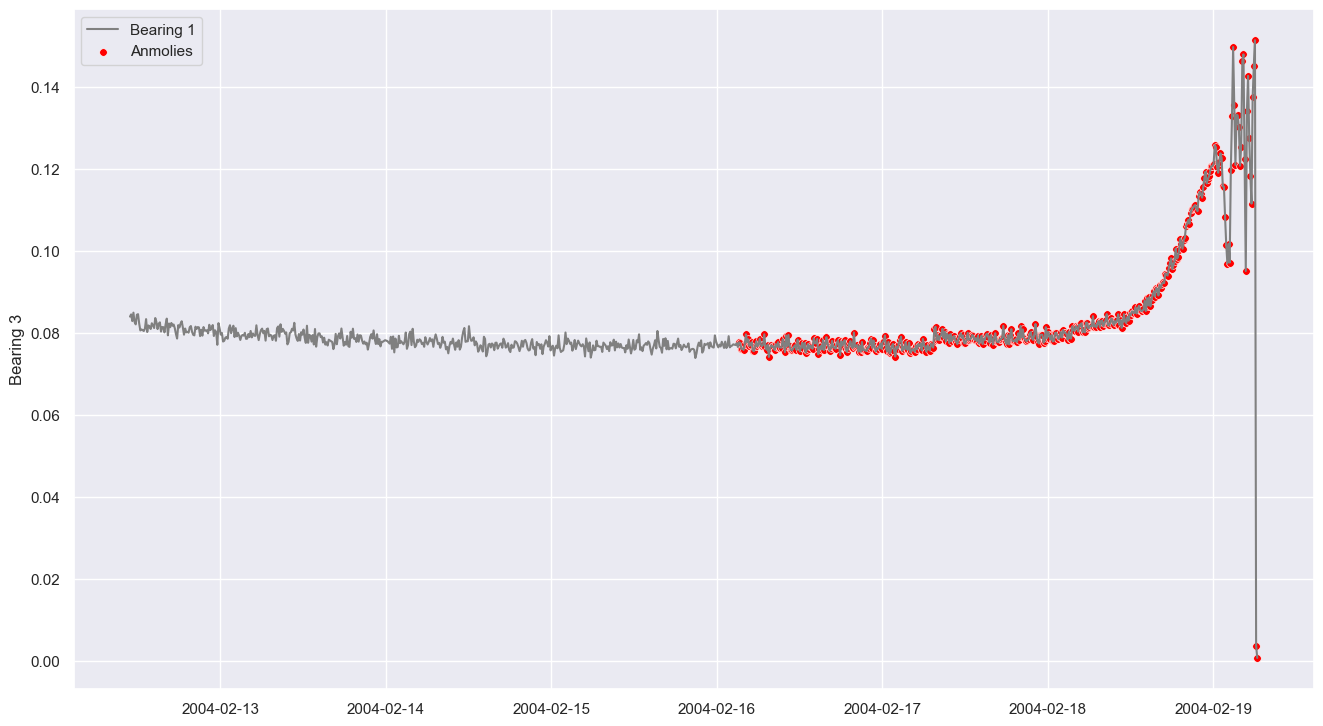

In [34]:
plt.figure(figsize = (16,9), dpi = 100)
plt.plot(scored.index, scored['Bearing 3'], color = 'gray', label = 'Bearing 1')
sns.scatterplot(anomalies.index, anomalies['Bearing 3'], color = 'red', label = 'Anmolies', s = 30)
plt.legend(loc='upper left')